# Bike Lane Data Transformations

## Purpose & Goal for this notebook

The goal for this notebook is to use the OSM dataset as the primary dataset with the other 2 datasets from Geoportal Berlin to verify that OSM fully covers the official bike lanes and that the official bike streets are correctly tagged in OSM.

The 2 core tables that are available for me to connect the final cleaned Bike_Lanes table into the ERD are called **`district`** and **`neighborhood`**. Specifically I will integrate the datasets using the `geometry`, `district_id` and `ditricts`. 

**How this connects to the existing/core tables**

- Coordinates (latitude, longitude, geom): link to neighbourhood and district polygons.
- Neighbourhood & district fields: join with administrative boundaries table.
- Source field: ensures traceability.


-------------------------
Steps: 

- Load the necessary Python libraries
- Upload the OSM, Fahrradstrassen and radverkehrsanlagen GeoJSON files
- Clean data
- Standardise column names for consistency
- Compare OSM and Datasets from Geoportal Berlin (ie. gaps, mismatches, etc.)
- Verify Fahrradstraßen tagging is consistent in the OSM dataset
- Create a unified dataset with OSM as the base with validations from the Geoportal Berlin datasets

## 1.  Loading the Libraries & Data

### Importing Libraries

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString
from geopandas.tools import sjoin_nearest

**Note:**

Following the uniformity of the rest of the ERD, the geometry of my table needs to be 'Point' so that lat/long can be extracted.

This will also be useful for later calculations of the length of the bike lanes. These lengths are calculated based on the geometry of each lane.

Currently, there is a discrepency in the Geometry between the OSM dataset and the Geoportal Berlin (Fahrradstraßen & Radverkehrsanlagen) datasets. Where the geometry from OSM is defined using `polygon` while the Geoportal Berlin datasets are defined as `MultiLineString` values. 

### Loading the Data

#### Dataset references:

1. **osm** = *OSM dataset*
2. **gbf** = *Geoportal Berlin Fahrradstrassen*
3. **gbr** = *Geoportal Berlin Radverkehrsanlagen*

In [5]:
osm = gpd.read_file("osm_bikelanes_raw.geojson")
gbf = gpd.read_file("fahrradstrassen.geojson")
gbr = gpd.read_file("radverkehrsanlagen.geojson") 

### Overview of Raw Data

In [6]:
print("OSM:", osm.shape)
print("Fahrradstraßen:", gbf.shape)
print("Radverkehrsanlagen:", gbr.shape)

OSM: (78865, 1064)
Fahrradstraßen: (57, 6)
Radverkehrsanlagen: (18641, 13)


#### OSM Dataset Basic Overview

In [7]:
print("OSM Bike Lanes Columns & Data Types")
osm.info()

OSM Bike Lanes Columns & Data Types
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78865 entries, 0 to 78864
Columns: 1064 entries, id to geometry
dtypes: datetime64[ms](22), geometry(1), object(1041)
memory usage: 640.2+ MB


##### Note: 
With a total of 1064 columns, having 1041 object columns, 22 datetime columns and 1 geometry column this is too much to keep for the purposes of the project. 

Based on the parameters of the project, the following columns will be isolated to keep the relevant fields: 

- *`osm_id`*
- *`street_name`*
- *`geometry`*
- *`cycleway`*
- *`smoothness`* (condition of bike lane - this column name will be changed to *`condition`*)
- *`surface`* (material type of the lane)
- *`highway`* (type of road)

#### Radsverkehrsanlagen Dataset Basic Overview

In [8]:
print("Radsverkehrsanlagen Columns & Data Types")
gbr.info()

Radsverkehrsanlagen Columns & Data Types
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18641 entries, 0 to 18640
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         18641 non-null  object  
 1   importid   18641 non-null  int32   
 2   sobj_kz    18641 non-null  object  
 3   segm_segm  18641 non-null  object  
 4   segm_bez   2430 non-null   object  
 5   stst_str   18641 non-null  object  
 6   stor_name  18641 non-null  object  
 7   ortstl     18641 non-null  object  
 8   rva_typ    18641 non-null  object  
 9   sorvt_typ  18641 non-null  object  
 10  laenge     18641 non-null  int32   
 11  b_pflicht  18641 non-null  object  
 12  geometry   18641 non-null  geometry
dtypes: geometry(1), int32(2), object(10)
memory usage: 1.7+ MB


##### Note:

As this dataset has come from an official German source, the column names and data are all in German. Below, I have listed the column names as originally shown in the datasource & the English version that I will be using in the final table.
Based on the parameters of the project, the following columns will be isolated to keep the relevant fields: 

- *`geometry`* = *`geometry`*
- *`strasse`* = *`street_name`*
- *`b_pflicht`* = *`condition`*
- *`laenge`* = *`length`*
- *`lane_type`*

#### Fahrradstraße Dataset Basic Overview

In [9]:
print("Fahrradstraße Columns & Data Types")
gbf.info()

Fahrradstraße Columns & Data Types
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         57 non-null     int32   
 1   bezirk     57 non-null     object  
 2   strasse    57 non-null     object  
 3   freigabe   57 non-null     object  
 4   abschnitt  33 non-null     object  
 5   geometry   57 non-null     geometry
dtypes: geometry(1), int32(1), object(4)
memory usage: 2.6+ KB


##### Note:

As this dataset has come from an official German source, the column names and data are all in German. Below, I have listed the column names as originally shown in the datasource & the English version that I will be using in the final table.
Based on the parameters of the project, the following columns will be isolated to keep the relevant fields: 

- *`geometry`* = *`geometry`*
- *`strasse`* = *`street_name`*

## 2. Normalising the Column Names & Data Types

### Ensuring Geometry Type is `Point`

#### Converting CRS to `(epsg=4326)`

In [10]:
osm = osm.to_crs(epsg=4326)
gbr = gbr.to_crs(epsg=4326)
gbf = gbf.to_crs(epsg=4326)

#### Converting Geometries (`Polygon`/`MultiLineString`) to `Point`

In [11]:
for gdf in [osm, gbr, gbf]:
    gdf["geometry"] = gdf["geometry"].apply(
        lambda geom: geom if geom.geom_type == "Point" else geom.representative_point()
    )

In [12]:
for gdf in [osm, gbr, gbf]:
    gdf["latitude"] = gdf.geometry.y
    gdf["longitude"] = gdf.geometry.x

In [13]:
print("✅ Geometry conversion complete:")
print(f"OSM geometry type: {osm.geometry.geom_type.unique()}")
print(f"Radverkehrsanlagen geometry type: {gbr.geometry.geom_type.unique()}")
print(f"Fahrradstraße geometry type: {gbf.geometry.geom_type.unique()}")

✅ Geometry conversion complete:
OSM geometry type: ['Point']
Radverkehrsanlagen geometry type: ['Point']
Fahrradstraße geometry type: ['Point']


In [14]:
osm[["id", "name", "latitude", "longitude"]].head()

,id,name,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,52.537608,13.602761
1,way/517805554,None,52.471086,13.463522
2,way/1186003574,None,52.589748,13.346163
3,way/1186011275,None,52.589653,13.345786
4,way/1187324842,None,52.487710,13.425639


### Selecting the relevant columns

#### OSM dataset as the base layer: 

In [15]:
osm_selected = (
    osm.rename(columns={
        "id": "bikelane_id",
        "name": "street_name",
        "smoothness": "condition"  # standardize naming for later integration
    })[[
        "bikelane_id",
        "street_name",
        "geometry",
        "cycleway",
        "condition",
        "surface",
        "highway",
        "latitude",
        "longitude"
    ]]
    .copy()
)

print("✅ OSM columns selected and renamed:")
print(osm_selected.columns.tolist())
osm_selected.head(3)

✅ OSM columns selected and renamed:
['bikelane_id', 'street_name', 'geometry', 'cycleway', 'condition', 'condition', 'surface', 'highway', 'latitude', 'longitude']


,bikelane_id,street_name,geometry,cycleway,condition,condition,surface,highway,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,good,asphalt,residential,52.537608,13.602761
1,way/517805554,None,POINT (13.46352 52.47109),no,None,good,paving_stones,service,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,52.589748,13.346163


#### Radverkehrsanlagen Relevant Colunms for Comparison:

In [16]:
gbr_selected = (
    gbr.rename(columns={
        "stst_str": "street_name",   # Straße name
        "b_pflicht": "condition",    # Ja/Nein for designated bike path
        "laenge": "length",          # Length in meters
        "rva_typ": "lane_type",      # Type of bike lane
    })[[
        "street_name",
        "geometry",
        "lane_type",
        "condition",
        "length",
        "latitude",
        "longitude"
    ]]
    .copy()
)

print("✅ Radverkehrsanlagen columns selected and renamed:")
print(gbr_selected.columns.tolist())
gbr_selected.head(3)

✅ Radverkehrsanlagen columns selected and renamed:
['street_name', 'geometry', 'lane_type', 'condition', 'length', 'latitude', 'longitude']


,street_name,geometry,lane_type,condition,length,latitude,longitude
0,Alt-Kaulsdorf,POINT (13.58237 52.50504),Radwege,ja,26,52.505039,13.582373
1,Alt-Mahlsdorf,POINT (13.60639 52.5047),Radwege,ja,16,52.504697,13.606394
2,Alt-Mahlsdorf,POINT (13.60253 52.50481),Radwege,nein,510,52.504813,13.602532


#### Fahrradstraße Relevant Colunms for Comparison:

In [17]:
gbf_selected = (
    gbf.rename(columns={
        "strasse": "street_name",
    })[[
        "street_name",
        "geometry",
        "latitude",
        "longitude"
    ]]
    .copy()
)

print("✅ Fahrradstraßen columns selected and renamed:")
print(gbf_selected.columns.tolist())
gbf_selected.head(3)

✅ Fahrradstraßen columns selected and renamed:
['street_name', 'geometry', 'latitude', 'longitude']


,street_name,geometry,latitude,longitude
0,Alberichstraße,POINT (13.55807 52.48607),52.486073,13.558070
1,Norwegerstraße,POINT (13.39943 52.55279),52.552792,13.399429
2,Schwedter Straße,POINT (13.40076 52.54785),52.547852,13.400758


In [18]:
print("OSM records:", len(osm_selected))
print("GBR records:", len(gbr_selected))
print("GBF records:", len(gbf_selected))

OSM records: 78865
GBR records: 18641
GBF records: 57


## 3. Comparing Data Coverage Between OSM & Geoportal Berlin Datasets

**Note:** 
This is a geometry and name based cross check which will help to verify the accuracy of the OSM dataset.



#### Step 1: **Temporarily** project to metric crs for accurate distance calculations

In [19]:
osm_m = osm_selected.to_crs(epsg=25833)
gbr_m = gbr_selected.to_crs(epsg=25833)
gbf_m = gbf_selected.to_crs(epsg=25833)


#### Step 2: Identify duplicatues using a nearest-neighbor spatial join

In [20]:
# GBR
gbr_to_osm = sjoin_nearest(
    gbr_m,
    osm_m[["geometry", "street_name"]],
    how="left",
    distance_col="distance_m"
)
gbr_to_osm["is_duplicate"] = (
    (gbr_to_osm["distance_m"] <= 50) &
    (gbr_to_osm["street_name_left"].str.lower().fillna("") ==
     gbr_to_osm["street_name_right"].str.lower().fillna(""))
)

# GBF
gbf_to_osm = sjoin_nearest(
    gbf_m,
    osm_m[["geometry", "street_name"]],
    how="left",
    distance_col="distance_m"
)
gbf_to_osm["is_duplicate"] = (
    (gbf_to_osm["distance_m"] <= 50) &
    (gbf_to_osm["street_name_left"].str.lower().fillna("") ==
     gbf_to_osm["street_name_right"].str.lower().fillna(""))
)

#### Step 3: Extract the missing features from Radverkehrsanlagen and Fahrradstraße

1 - Ensure alignment by resetting indices

In [21]:
osm_selected = osm_selected.reset_index(drop=True)
gbr_selected = gbr_selected.reset_index(drop=True)
gbf_selected = gbf_selected.reset_index(drop=True)

2 - Flagging the duplicates from the Geoportal Berlin datasets

In [22]:
gbr_selected["is_duplicate"] = gbr_to_osm["is_duplicate"].reset_index(drop=True)
gbf_selected["is_duplicate"] = gbf_to_osm["is_duplicate"].reset_index(drop=True)

3 - Filtering out only the missing features

In [23]:
gbr_missing = gbr_selected.loc[~gbr_selected["is_duplicate"]].copy()
gbf_missing = gbf_selected.loc[~gbf_selected["is_duplicate"]].copy()

4 - Dropping the support column

In [24]:
gbr_missing = gbr_missing.drop(columns="is_duplicate")
gbf_missing = gbf_missing.drop(columns="is_duplicate")

5 - Checking the results

In [25]:
print("New GBR lanes to add:", len(gbr_missing))
print("New GBF lanes to add:", len(gbf_missing))

New GBR lanes to add: 9470
New GBF lanes to add: 39


#### Step 4: Merging the missing featurs from Geoprotal Berlin to the OSM base layer

In [26]:
from shapely.geometry import Point

def convert_to_point(gdf):
    """Convert all geometries to POINT and keep longitude/latitude."""
    gdf = gdf.to_crs(epsg=4326).copy()
    gdf["geometry"] = gdf["geometry"].apply(
        lambda geom: geom if geom.geom_type == "Point" else geom.representative_point()
    )
    gdf["latitude"] = gdf.geometry.y
    gdf["longitude"] = gdf.geometry.x
    return gdf

2 - convert missing features to "Point"

In [27]:
gbr_missing_points = convert_to_point(gbr_missing)
gbf_missing_points = convert_to_point(gbf_missing)
osm_points = convert_to_point(osm_selected)

3 - Keep only the relevant columns for the final table

In [28]:
gbr_cols = ["street_name", "geometry", "lane_type", "condition", "length", "latitude", "longitude"]
gbf_cols = ["street_name", "geometry", "latitude", "longitude"]  
osm_cols = ["bikelane_id", "street_name", "geometry", "cycleway", "condition", "surface", "highway", "latitude", "longitude"]

gbr_missing_points = gbr_missing_points[gbr_cols]
gbf_missing_points = gbf_missing_points[gbf_cols]
osm_points = osm_points[osm_cols]

## 4. Create an Initial Single Unified Dataset

**Note:** This is an initial unification, further transformations will be made where there will have to be other integrations into the table

### Align columns for concatenation

In [30]:
final_columns = [
    "bikelane_id", "street_name", "geometry", "cycleway",
    "condition", "surface", "highway", "lane_type", "length",
    "latitude", "longitude"
]

### Ensure all datas have the same columns

In [31]:
def align_columns(gdf, columns):
    for col in columns:
        if col not in gdf.columns:
            gdf[col] = None  # Fill missing columns with None
    return gdf[columns]

osm_aligned = align_columns(osm_points, final_columns)
gbr_aligned = align_columns(gbr_missing_points, final_columns)
gbf_aligned = align_columns(gbf_missing_points, final_columns)

### Concatenate the datasets

In [32]:
osm_aligned = osm_aligned.loc[:, ~osm_aligned.columns.duplicated()]
gbr_aligned = gbr_aligned.loc[:, ~gbr_aligned.columns.duplicated()]
gbf_aligned = gbf_aligned.loc[:, ~gbf_aligned.columns.duplicated()]

In [33]:
bike_lanes_final = pd.concat([osm_aligned, gbr_aligned, gbf_aligned], ignore_index=True)

In [34]:
print("✅ Final unified dataset shape:", bike_lanes_final.shape)
print("✅ Columns:", bike_lanes_final.columns.tolist())
bike_lanes_final.head(5)

✅ Final unified dataset shape: (88374, 11)
✅ Columns: ['bikelane_id', 'street_name', 'geometry', 'cycleway', 'condition', 'surface', 'highway', 'lane_type', 'length', 'latitude', 'longitude']


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,asphalt,residential,None,None,52.537608,13.602761
1,way/517805554,None,POINT (13.46352 52.47109),no,None,paving_stones,service,None,None,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639


## 5. Inspecting the Preliminary table

### Ensuring CRS is `epsg=4326`

In [35]:
bike_lanes_final = bike_lanes_final.set_geometry("geometry").to_crs(epsg=4326)

### Ensure all geometries are POINT

In [36]:
bike_lanes_final["geometry"] = bike_lanes_final["geometry"].apply(
    lambda geom: geom if geom.geom_type == "Point" else geom.representative_point()
)

### Confirm that Longitude and Latitude have been Extracted from the Geometry

In [37]:
bike_lanes_final["latitude"] = bike_lanes_final.geometry.y
bike_lanes_final["longitude"] = bike_lanes_final.geometry.x

### Quick Confirmation of Table

In [38]:
print("✅ Final dataset ready for ERD/database")
print("Shape:", bike_lanes_final.shape)
print(bike_lanes_final[["bikelane_id", "street_name", "latitude", "longitude"]].head())

✅ Final dataset ready for ERD/database
Shape: (88374, 11)
      bikelane_id       street_name   latitude  longitude
0    way/43998936  Fritz-Lang-Platz  52.537608  13.602761
1   way/517805554              None  52.471086  13.463522
2  way/1186003574              None  52.589748  13.346163
3  way/1186011275              None  52.589653  13.345786
4  way/1187324842              None  52.487710  13.425639


In [39]:
bike_lanes_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 88374 entries, 0 to 88373
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bikelane_id  78865 non-null  object  
 1   street_name  75437 non-null  object  
 2   geometry     88374 non-null  geometry
 3   cycleway     6479 non-null   object  
 4   condition    9471 non-null   object  
 5   surface      76376 non-null  object  
 6   highway      78854 non-null  object  
 7   lane_type    9470 non-null   object  
 8   length       9470 non-null   object  
 9   latitude     88374 non-null  float64 
 10  longitude    88374 non-null  float64 
dtypes: float64(2), geometry(1), object(8)
memory usage: 7.4+ MB


## 6. Data Summary & Identifying Null Values

### Initial Summary Table

In [40]:
summary_data = []

# Total number of rows
total_rows = len(bike_lanes_final)

# Loop through each column
for col in bike_lanes_final.columns:
    num_nulls = bike_lanes_final[col].isna().sum()
    num_unique = bike_lanes_final[col].nunique()
    num_non_null_values = total_rows - num_nulls
    summary_data.append({
        "column": col,
        "total_rows": total_rows,
        "num_unique": num_unique,
        "num_nulls": num_nulls,
        "num_non_null_values": num_non_null_values
    })

# Convert to DataFrame
eda_summary = pd.DataFrame(summary_data)

# Display
print(eda_summary)

         column  total_rows  num_unique  num_nulls  num_non_null_values
0   bikelane_id       88374       78865       9509                78865
1   street_name       88374        8470      12937                75437
2      geometry       88374       84822          0                88374
3      cycleway       88374          15      81895                 6479
4     condition       88374           3      78903                 9471
5       surface       88374          30      11998                76376
6       highway       88374          23       9520                78854
7     lane_type       88374           4      78904                 9470
8        length       88374         651      78904                 9470
9      latitude       88374       83382          0                88374
10    longitude       88374       84116          0                88374


### A Closer Look at Null Values

#### Missing `bikelane_id`

In [41]:
missing_bikelane_id = bike_lanes_final[bike_lanes_final["bikelane_id"].isna()]
print("Number of missing bikelane_id:", len(missing_bikelane_id))
missing_bikelane_id.head(10)

Number of missing bikelane_id: 9509


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
78865,None,Alt-Kaulsdorf,POINT (13.58237 52.50504),None,ja,None,None,Radwege,26,52.505039,13.582373
78866,None,Alt-Mahlsdorf,POINT (13.60253 52.50481),None,nein,None,None,Radwege,510,52.504813,13.602532
78867,None,Tychyer Straße,POINT (13.56535 52.50716),None,nein,None,None,Schutzstreifen,15,52.507164,13.565349
78868,None,Alt-Biesdorf,POINT (13.56726 52.5067),None,ja,None,None,Radwege,216,52.506698,13.567265
78869,None,Alt-Biesdorf,POINT (13.56861 52.50633),None,ja,None,None,Radwege,34,52.506328,13.568612
78870,None,Apollofalterallee,POINT (13.5687 52.50622),None,nein,None,None,Radwege,20,52.506215,13.568702
78871,None,Alt-Biesdorf,POINT (13.57144 52.50555),None,ja,None,None,Radwege,96,52.505555,13.571442
78872,None,Alt-Biesdorf,POINT (13.57261 52.5053),None,ja,None,None,Radwege,34,52.505302,13.572610
78873,None,Alt-Biesdorf,POINT (13.57325 52.5052),None,ja,None,None,Radwege,79,52.505198,13.573254
78874,None,Alt-Biesdorf,POINT (13.57375 52.50516),None,ja,None,None,Radwege,9,52.505162,13.573752


#### Missing `street_name`

In [42]:
missing_street_names = bike_lanes_final[bike_lanes_final["street_name"].isna()]
print("Number of missing street names:", len(missing_street_names))
missing_street_names.head(10)

Number of missing street names: 12937


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
1,way/517805554,None,POINT (13.46352 52.47109),no,None,paving_stones,service,None,None,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
364,way/4410020,None,POINT (13.30642 52.56806),None,None,asphalt,secondary_link,None,None,52.568058,13.306425
380,way/4410450,None,POINT (13.32853 52.53295),None,None,asphalt,secondary,None,None,52.532951,13.328525
401,way/4413383,None,POINT (13.29855 52.54685),None,None,asphalt,motorway_link,None,None,52.546853,13.298555
402,way/4413385,None,POINT (13.29805 52.54621),None,None,asphalt,motorway_link,None,None,52.546205,13.298048
410,way/4420986,None,POINT (13.23602 52.46948),None,None,concrete:plates,service,None,None,52.469481,13.236024
435,way/4429742,None,POINT (13.29305 52.58273),None,None,asphalt,cycleway,None,None,52.582734,13.293052


#### Missing `cycleway`

In [43]:
missing_cycleway = bike_lanes_final[bike_lanes_final["cycleway"].isna()]
print("Number of missing cycleway:", len(missing_cycleway))
missing_cycleway.head(10)

Number of missing cycleway: 81895


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,asphalt,residential,None,None,52.537608,13.602761
5,way/4045194,Ursula-Goetze-Straße,POINT (13.53144 52.49328),None,None,asphalt,residential,None,None,52.493280,13.531443
6,way/4045220,Hönower Straße,POINT (13.52639 52.48925),None,None,sett,residential,None,None,52.489245,13.526386
7,way/4045223,Gundelfinger Straße,POINT (13.52495 52.48614),None,None,sett,residential,None,None,52.486142,13.524950
8,way/4045243,Frankfurter Allee,POINT (13.45472 52.51566),None,None,asphalt,primary,None,None,52.515659,13.454722
10,way/4054013,Michael-Brückner-Straße,POINT (13.51531 52.45268),None,None,asphalt,primary,None,None,52.452676,13.515314
11,way/4067882,Olympische Straße,POINT (13.24967 52.51549),None,None,asphalt,secondary,None,None,52.515493,13.249674
12,way/4067883,Jafféstraße,POINT (13.26336 52.50676),None,None,asphalt,secondary,None,None,52.506764,13.263359
13,way/4067902,Müllerstraße,POINT (13.33337 52.56106),None,None,asphalt,primary,None,None,52.561062,13.333367
14,way/4067919,Köpenicker Landstraße,POINT (13.49481 52.46688),None,None,asphalt,primary,None,None,52.466878,13.494808


#### Missing `condition`

In [44]:
missing_condition = bike_lanes_final[bike_lanes_final["condition"].isna()]
print("Number of missing condition:", len(missing_condition))
missing_condition.head(10)

Number of missing condition: 78903


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,asphalt,residential,None,None,52.537608,13.602761
1,way/517805554,None,POINT (13.46352 52.47109),no,None,paving_stones,service,None,None,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
5,way/4045194,Ursula-Goetze-Straße,POINT (13.53144 52.49328),None,None,asphalt,residential,None,None,52.493280,13.531443
6,way/4045220,Hönower Straße,POINT (13.52639 52.48925),None,None,sett,residential,None,None,52.489245,13.526386
7,way/4045223,Gundelfinger Straße,POINT (13.52495 52.48614),None,None,sett,residential,None,None,52.486142,13.524950
8,way/4045243,Frankfurter Allee,POINT (13.45472 52.51566),None,None,asphalt,primary,None,None,52.515659,13.454722
9,way/4045656,Hauptstraße,POINT (13.37112 52.5909),track,None,asphalt,secondary,None,None,52.590897,13.371120


#### Missing `surface`

In [45]:
missing_surface = bike_lanes_final[bike_lanes_final["surface"].isna()]
print("Number of missing surface:", len(missing_surface))
missing_surface.head(10)

Number of missing surface: 11998


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
88,way/4359603,Kirchblick,POINT (13.21945 52.43879),None,None,None,residential,None,None,52.438795,13.219447
94,way/4359663,Waldsängerpfad,POINT (13.20794 52.43652),None,None,None,residential,None,None,52.436519,13.207942
419,way/4424204,Heidestraße,POINT (13.15468 52.41629),None,None,None,residential,None,None,52.416290,13.154682
422,way/4424208,Charlottenstraße,POINT (13.14549 52.41526),None,None,None,residential,None,None,52.415262,13.145488
425,way/4424211,Wickenhagenweg,POINT (13.15712 52.41725),None,None,None,residential,None,None,52.417249,13.157123
1719,way/4588775,Wirmerzeile,POINT (13.30188 52.53692),None,None,None,residential,None,None,52.536915,13.301883
1720,way/4588776,Schwambzeile,POINT (13.30118 52.53804),None,None,None,residential,None,None,52.538042,13.301180


#### Missing `highway` - 9520

In [46]:
missing_highway = bike_lanes_final[bike_lanes_final["highway"].isna()]
print("Number of missing highway:", len(missing_highway))
missing_highway.head(10)

Number of missing highway: 9520


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
3079,way/4696049,Landsberger Allee,POINT (13.53761 52.53921),None,None,asphalt,None,None,None,52.539211,13.537609
3080,way/4696050,Landsberger Allee,POINT (13.53768 52.53922),None,None,asphalt,None,None,None,52.539218,13.537678
3081,way/4696051,Landsberger Allee,POINT (13.53919 52.53943),None,None,asphalt,None,None,None,52.539428,13.539190
23989,way/293906282,Landsberger Allee,POINT (13.53694 52.53914),None,None,asphalt,None,None,None,52.539140,13.536941
24175,way/304488118,None,POINT (13.24216 52.52519),None,None,None,None,None,None,52.525194,13.242161
24195,way/305265130,None,POINT (13.32199 52.47551),None,None,None,None,None,None,52.475508,13.321989
30486,way/663861521,Am Gehrensee,POINT (13.56311 52.57433),None,None,None,None,None,None,52.574326,13.563105


#### Missing `lane_type` - 78904

In [47]:
missing_lane_type = bike_lanes_final[bike_lanes_final["lane_type"].isna()]
print("Number of missing lane_type:", len(missing_lane_type))
missing_lane_type.head(10)

Number of missing lane_type: 78904


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,asphalt,residential,None,None,52.537608,13.602761
1,way/517805554,None,POINT (13.46352 52.47109),no,None,paving_stones,service,None,None,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
5,way/4045194,Ursula-Goetze-Straße,POINT (13.53144 52.49328),None,None,asphalt,residential,None,None,52.493280,13.531443
6,way/4045220,Hönower Straße,POINT (13.52639 52.48925),None,None,sett,residential,None,None,52.489245,13.526386
7,way/4045223,Gundelfinger Straße,POINT (13.52495 52.48614),None,None,sett,residential,None,None,52.486142,13.524950
8,way/4045243,Frankfurter Allee,POINT (13.45472 52.51566),None,None,asphalt,primary,None,None,52.515659,13.454722
9,way/4045656,Hauptstraße,POINT (13.37112 52.5909),track,None,asphalt,secondary,None,None,52.590897,13.371120


#### Missing `length` - 78904

In [48]:
missing_length = bike_lanes_final[bike_lanes_final["length"].isna()]
print("Number of missing length:", len(missing_length))
missing_length.head(10)

Number of missing length: 78904


,bikelane_id,street_name,geometry,cycleway,condition,surface,highway,lane_type,length,latitude,longitude
0,way/43998936,Fritz-Lang-Platz,POINT (13.60276 52.53761),None,None,asphalt,residential,None,None,52.537608,13.602761
1,way/517805554,None,POINT (13.46352 52.47109),no,None,paving_stones,service,None,None,52.471086,13.463522
2,way/1186003574,None,POINT (13.34616 52.58975),lane,None,None,None,None,None,52.589748,13.346163
3,way/1186011275,None,POINT (13.34579 52.58965),lane,None,None,None,None,None,52.589653,13.345786
4,way/1187324842,None,POINT (13.42564 52.48771),crossing,None,None,None,None,None,52.487710,13.425639
5,way/4045194,Ursula-Goetze-Straße,POINT (13.53144 52.49328),None,None,asphalt,residential,None,None,52.493280,13.531443
6,way/4045220,Hönower Straße,POINT (13.52639 52.48925),None,None,sett,residential,None,None,52.489245,13.526386
7,way/4045223,Gundelfinger Straße,POINT (13.52495 52.48614),None,None,sett,residential,None,None,52.486142,13.524950
8,way/4045243,Frankfurter Allee,POINT (13.45472 52.51566),None,None,asphalt,primary,None,None,52.515659,13.454722
9,way/4045656,Hauptstraße,POINT (13.37112 52.5909),track,None,asphalt,secondary,None,None,52.590897,13.371120


## 7. Addressing the Missing Values in the `street_name` column
**Including:**
1. Reverse Geocoding to extract street names using the longitude/latitude that was extracted from the geometry.
2. Data quality check.
3. Integration of the street names into the main dataset.
4. Validating the data merge.

### 7.1. Reverse Geocoding

#### Loading Libraries 

In [49]:
from geopy.geocoders import Nominatim
from time import sleep
from tqdm.notebook import tqdm

#### Initialising a New Nominatim Geocoder for Retrieving Street Names

In [50]:
geolocator = Nominatim(user_agent="berlin_bikelanes_locator")

#### Defining Reverse Geocoding Function to Extract Street Names

In [51]:
def get_street_name(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        sleep(1)  # respect Nominatim API rate limits
        if location and "address" in location.raw:
            address = location.raw["address"]
            # Try multiple possible fields for road name
            return (
                address.get("road")
                or address.get("pedestrian")
                or address.get("footway")
                or address.get("street")
                or None
            )
        return None
    except Exception as e:
        print(f"Error at ({lat}, {lon}): {e}")
        return None

#### Selecting the Rows with Missing `street_name`Values

In [52]:
missing_street_rows = bike_lanes_final[bike_lanes_final["street_name"].isna()].copy()

#### Implement Progress Tracking

In [53]:
tqdm.pandas()

#### Initial run for the Reverse Geocoding

**Note:** There was a failure in this first implementation of the Reverse Geoocoding where I had to cancel the running of the cell and revisit the script to run the Reverse Geocoding successfully

In [54]:
results = []

In [55]:
SAVE_INTERVAL = 200

In [56]:
for i, row in tqdm(missing_street_rows.iterrows(), total=len(missing_street_rows)):
    lat, lon = row["latitude"], row["longitude"]
    street_name = get_street_name(lat, lon)
    
    results.append({
        "latitude": lat,
        "longitude": lon,
        "street_name_filled": street_name
    })

  0%|          | 0/12937 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if (i + 1) % SAVE_INTERVAL == 0:
        partial_df = pd.DataFrame(results)
        partial_df.to_csv("street_name_progress.csv", index=False)
        print(f"✅ Saved progress after {i + 1} rows...")

In [ ]:
import pandas as pd

# Save current progress (whatever is in memory)
partial_df = pd.DataFrame(results)
partial_df.to_csv("street_name_progress_partial.csv", index=False)
print(f"💾 Saved {len(partial_df)} partial reverse-geocoded results to street_name_progress_partial.csv")

💾 Saved 1864 partial reverse-geocoded results to street_name_progress_partial.csv


#### Revised Reverse Geocoding 

Below, you will find cells similar to that of the cells above. This is because after 173 minutes of running the reverse geocoding function, I had approximately 14% of the null values processed but the following error message occured: 

`Error at (52.5255788, 13.5403042): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=52.5255788&lon=13.5403042&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))`

**According to further research, this error may have occured based on the following:**
1. Nominatim is rate-limited and sensitive to many requests or network lags.
2. The default timeout miay be too short for such a large dataset (12937 missing `street_name`records)

**Suggested solution based on research:**
Write an improved version of the code that includes a longer timout and 'retry' logic to skip or retry failed requests. 

**Adjusted Reverse Geocoding Implementation Plan**
1. Rerun library imports to be safe.
2. Re-initialise geolocator.
3. Redefine reverse geocoding function with retries (a safety mechanism incase issues arise and the sleep rate is reduce by 0.5 seconds for faster processing time while keeping the code limitations in mind).
4. Load partial results (saved from first attempt to reverse geocode street names).
5. Prepare the missing rows to process.
6. Re-run reverse geocoding loop with partial saves as a safety mechanism. (crashed again and had to rewrite some of the code)
7. Save the completed results.

In [57]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from time import sleep
from tqdm.notebook import tqdm

In [ ]:
geolocator = Nominatim(user_agent="berlin_bikelanes_locator")

In [ ]:
def get_street_name(lat, lon, max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True)
            sleep(1) # to avoid being blocked by API
            if location and "address" in location.raw:
                address = location.raw["address"]
                return (
                    address.get("road")
                    or address.get("pedestrian")
                    or address.get("footway")
                    or address.get("street")
                    or None
                )
            return None
        except GeocoderTimedOut:
            attempt += 1
            print(f"⚠️ Timeout at ({lat}, {lon}), retrying {attempt}/{max_retries}...")
            sleep(2)  # longer backoff
        except Exception as e:
            print(f"❌ Error at ({lat}, {lon}): {e}")
            return None
    print(f"❌ Failed after {max_retries} retries: ({lat}, {lon})")
    return None

In [ ]:
missing_street_rows = bike_lanes_final[bike_lanes_final["street_name"].isna()].copy()
tqdm.pandas()
results = []

SAVE_INTERVAL = 200

In [ ]:
import os

partial_file = "street_name_progress_partial.csv"

if os.path.exists(partial_file):
    print("📂 Found partial progress, loading...")
    partial_df = pd.read_csv(partial_file)
    results = partial_df.to_dict(orient="records")
    
    # Remove rows already processed from missing_street_rows
    processed_coords = set(zip(partial_df.latitude, partial_df.longitude))
    missing_street_rows = missing_street_rows[
        ~missing_street_rows.apply(lambda r: (r.latitude, r.longitude) in processed_coords, axis=1)
    ]
    
    print(f"⏩ Resuming with {len(missing_street_rows)} rows remaining...")

📂 Found partial progress, loading...
⏩ Resuming with 10905 rows remaining...


In [ ]:
# Filter rows that still need street names
processed_coords = {(r['latitude'], r['longitude']) for r in results}  # coords already processed
missing_street_rows = bike_lanes_final[bike_lanes_final["street_name"].isna()].copy()

# Keep only rows not yet processed
rows_to_process = missing_street_rows[~missing_street_rows.apply(lambda r: (r["latitude"], r["longitude"]) in processed_coords, axis=1)]
print(f"ℹ️ {len(rows_to_process)} rows remaining to process.")

ℹ️ 11041 rows remaining to process.


In [ ]:
for i, row in tqdm(missing_street_rows.iterrows(), total=len(missing_street_rows)):
    lat, lon = row["latitude"], row["longitude"]
    street_name = get_street_name(lat, lon)
    
    results.append({
        "latitude": lat,
        "longitude": lon,
        "street_name_filled": street_name
    })
    
    if (i + 1) % SAVE_INTERVAL == 0:
        partial_df = pd.DataFrame(results)
        partial_df.to_csv(partial_file, index=False)
        print(f"💾 Saved progress after {i + 1} rows...")

# Save final results
final_results_df = pd.DataFrame(results)
final_results_df.to_csv("street_name_progress_final.csv", index=False)
print(f"✅ Reverse geocoding complete. Total rows processed: {len(final_results_df)}")

  0%|          | 0/10905 [00:00<?, ?it/s]

💾 Saved progress after 30000 rows...
💾 Saved progress after 31000 rows...
💾 Saved progress after 32000 rows...
💾 Saved progress after 32200 rows...
💾 Saved progress after 33000 rows...
💾 Saved progress after 33600 rows...
💾 Saved progress after 33800 rows...
💾 Saved progress after 34200 rows...
💾 Saved progress after 34800 rows...
❌ Error at (52.5522585, 13.2488022): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=52.5522585&lon=13.2488022&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
❌ Error at (52.6028242, 13.3331901): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=52.6028242&lon=13.3331901&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"

### 7.2. Data Quality Check

#### Loading the final geocoded results

In [58]:
geocoded_df = pd.read_csv("street_name_progress_final.csv")
geocoded_df.head()

,latitude,longitude,street_name_filled
0,52.471086,13.463522,Sonnenallee
1,52.589748,13.346163,Schorfheidestraße
2,52.589653,13.345786,Am Nordgraben
3,52.487710,13.425639,Sonnenallee
4,52.568058,13.306425,Scharnweberstraße


#### Basic Data Quality Check

In [59]:
geocoded_df.info()
geocoded_df.isna().sum()
geocoded_df["street_name_filled"].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12905 entries, 0 to 12904
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            12905 non-null  float64
 1   longitude           12905 non-null  float64
 2   street_name_filled  12658 non-null  object 
dtypes: float64(2), object(1)
memory usage: 302.6+ KB


2318

Based on the data quality check, we have the following results:
1. A total of 12905 records.
2. We **still** have *(12905 - 12658)* 247 records missing which makes up *(247/12905 * 100)* 1.91% of the records missing.  

#### Possible Duplicates

In [60]:
duplicates = geocoded_df[geocoded_df.duplicated(subset=["latitude", "longitude"], keep=False)]
print(len(duplicates))
duplicates.head()

462


,latitude,longitude,street_name_filled
3,52.487710,13.425639,Sonnenallee
32,52.560441,13.321850,Kurt-Schumacher-Damm
33,52.560441,13.321850,Kurt-Schumacher-Damm
35,52.550109,13.295809,NaN
36,52.549612,13.295961,NaN


Based on the duplicates check, we have the following results:

1. 462 rows with the same longitude/latitude.

Plan to address duplicates:
1. Drop one copy of the duplicate pairs.
*Check if one of the duplicates of the longitude/latitude don't have street names (NaN value) and preferably drop the duplicate with the NaN value*

In [61]:
# Check if how many pairs of duplicates possibly have NaN values
duplicates["street_name_filled"].isna().sum()

np.int64(14)

In [62]:
# Previewing if both records have duplicate NaN values
duplicates[duplicates["street_name_filled"].isna()].head(14)

,latitude,longitude,street_name_filled
35,52.550109,13.295809,NaN
36,52.549612,13.295961,NaN
51,52.576305,13.294564,NaN
61,52.550109,13.295809,NaN
509,52.576305,13.294564,NaN
633,52.549612,13.295961,NaN
1709,52.499386,13.388892,NaN
1769,52.499386,13.388892,NaN
2422,52.601794,13.303236,NaN
3724,52.601794,13.303236,NaN


In [63]:
# Previewing if any of the duplicate values have 1 with a street_name and 1 with an NaN value
mixed_groups = (
    duplicates.groupby(["latitude", "longitude"])["street_name_filled"]
    .apply(lambda x: x.isna().any() and x.notna().any())
)

mixed_groups.value_counts()

street_name_filled
False    228
Name: count, dtype: int64

In [64]:
# Sort so that non-null street names come first
geocoded_df = geocoded_df.sort_values(
    by=["latitude", "longitude", "street_name_filled"],
    ascending=[True, True, True]
)

#### Conjecture on remaining Missing Values after Reverse Geocoding

Based on some further research, I found that there may be a possibility where Nominatim may not be able to pick up some of the names of streets based on the provided longitude/latitude due to clustering in certain areas (like around bodies of water, parks, industrial areas, etc.)  


In [65]:
import matplotlib.pyplot as plt

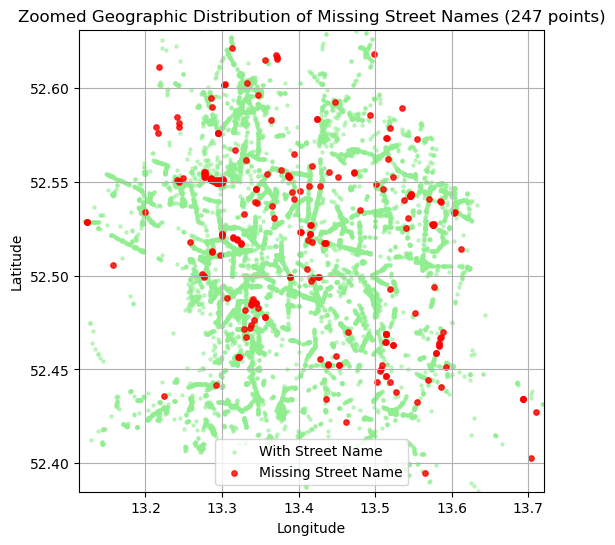

In [66]:
# Filter for missing street names
missing_streets = geocoded_df[geocoded_df["street_name_filled"].isna()]

# Define the plot limits based on the min/max of missing points, with a buffer
lon_min, lon_max = missing_streets["longitude"].min() - 0.01, missing_streets["longitude"].max() + 0.01
lat_min, lat_max = missing_streets["latitude"].min() - 0.01, missing_streets["latitude"].max() + 0.01

plt.figure(figsize=(6, 6))

# Plot all points
plt.scatter(geocoded_df["longitude"], geocoded_df["latitude"], 
            s=5, color="lightgreen", label="With Street Name", alpha=0.5)

# Plot missing points
plt.scatter(missing_streets["longitude"], missing_streets["latitude"], 
            s=15, color="red", label="Missing Street Name", alpha=0.8)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Zoomed Geographic Distribution of Missing Street Names ({len(missing_streets)} points)")
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Round coordinates to 5 decimal places (≈1 meter precision)
rounded_dupes = (
    geocoded_df
    .assign(
        lat_round=geocoded_df["latitude"].round(5),
        lon_round=geocoded_df["longitude"].round(5)
    )
    .duplicated(subset=["lat_round", "lon_round"])
    .sum()
)
print(f"Potential near-duplicate coordinate pairs (within ~1m): {rounded_dupes}")

Potential near-duplicate coordinate pairs (within ~1m): 236


### 7.3. Integrating Reverse Geocoded `street_name` Column back into Main Dataset

I only performed the reverse geocoding on the rows that had missing street names  and then I saved those results into a partial (result of the 1st interrupted geocoding run) & final results table, with the following columns: **`latitude`**. **`longitude`**, **`street_name_filled`**. Based on this logic, I can directly reattach the `bikelane_id` column to the relative rows which I will then use as a primary key to merge this data back into the main table. 

#### Step 1: Create the table that will be used to merge later on.

In [68]:
coords_with_id = bike_lanes_final.loc[
    bike_lanes_final["street_name"].isna(),
    ["bikelane_id", "latitude", "longitude"]
].copy()

coords_with_id.to_csv("missing_street_coords_with_id.csv", index=False)
print(f"✅ Saved {len(coords_with_id)} rows for re-geocoding with IDs.")

✅ Saved 12937 rows for re-geocoding with IDs.


#### Step 2: Link `bikelane_id` Back to Geocoded Results

In [69]:
# Load both tables
geocoded_results = pd.read_csv("street_name_progress_final.csv")
coords_with_id = pd.read_csv("missing_street_coords_with_id.csv")

# Merge by coordinates
geocoded_with_id = (
    coords_with_id
    .merge(
        geocoded_results,
        on=["latitude", "longitude"],
        how="left"
    )
)

print("✅ Geocoded results with IDs shape:", geocoded_with_id.shape)
geocoded_with_id.head()

✅ Geocoded results with IDs shape: (13413, 4)


,bikelane_id,latitude,longitude,street_name_filled
0,way/517805554,52.471086,13.463522,Sonnenallee
1,way/1186003574,52.589748,13.346163,Schorfheidestraße
2,way/1186011275,52.589653,13.345786,Am Nordgraben
3,way/1187324842,52.487710,13.425639,Sonnenallee
4,way/1187324842,52.487710,13.425639,Sonnenallee


#### Merging the `street_name_filled` back into Main Dataset

In [70]:
bike_lanes_enriched = bike_lanes_final.copy()

bike_lanes_enriched = (
    bike_lanes_enriched
    .merge(
        geocoded_with_id[["bikelane_id", "street_name_filled"]],
        on="bikelane_id",
        how="left"
    )
)

bike_lanes_enriched["street_name"] = bike_lanes_enriched["street_name"].fillna(
    bike_lanes_enriched["street_name_filled"]
)

bike_lanes_enriched = bike_lanes_enriched.drop(columns=["street_name_filled"])
print("✅ Merged dataset shape:", bike_lanes_enriched.shape)

✅ Merged dataset shape: (88850, 11)


#### Verifying that all `street_name`s are filled

In [71]:
missing_after_merge = bike_lanes_enriched["street_name"].isna().sum()
print(f"Remaining missing street names: {missing_after_merge}")

Remaining missing street names: 264


#### Checking Where the remaining missing `street_name` values are

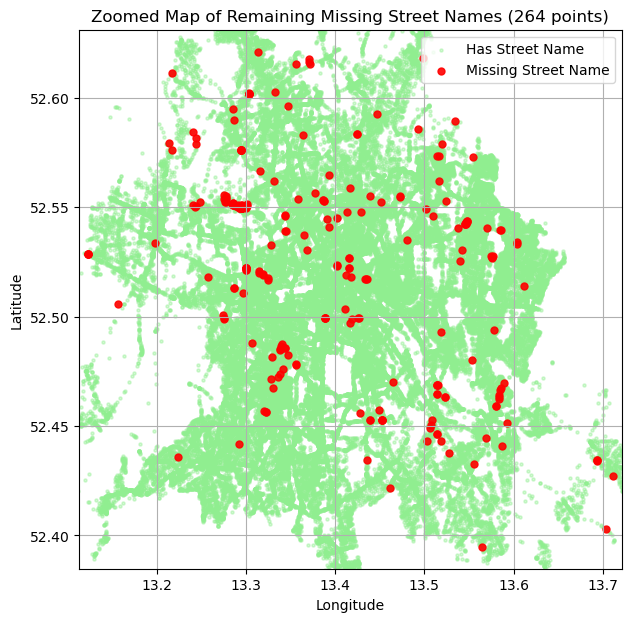

In [72]:
import matplotlib.pyplot as plt

# Filter missing street names
missing = bike_lanes_enriched[bike_lanes_enriched["street_name"].isna()].copy()

# Calculate plot limits with a small buffer
lon_min, lon_max = missing["longitude"].min() - 0.01, missing["longitude"].max() + 0.01
lat_min, lat_max = missing["latitude"].min() - 0.01, missing["latitude"].max() + 0.01

# Create the plot
plt.figure(figsize=(7, 7))

# Plot all points (with street names)
plt.scatter(
    bike_lanes_enriched["longitude"], 
    bike_lanes_enriched["latitude"],
    s=5, color="lightgreen", alpha=0.4, label="Has Street Name"
)

# Plot missing points
plt.scatter(
    missing["longitude"],
    missing["latitude"],
    s=25, color="red", alpha=0.9, label="Missing Street Name"
)

# Apply zoom based on missing data bounds
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Zoomed Map of Remaining Missing Street Names ({len(missing)} points)")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
summary_data = []

# Total number of rows
total_rows = len(bike_lanes_enriched)

# Loop through each column
for col in bike_lanes_enriched.columns:
    num_nulls = bike_lanes_enriched[col].isna().sum()
    num_unique = bike_lanes_enriched[col].nunique()
    num_non_null_values = total_rows - num_nulls
    summary_data.append({
        "column": col,
        "total_rows": total_rows,
        "num_unique": num_unique,
        "num_nulls": num_nulls,
        "num_non_null_values": num_non_null_values
    })

# Convert to DataFrame
eda_summary = pd.DataFrame(summary_data)

# Display
print(eda_summary)

         column  total_rows  num_unique  num_nulls  num_non_null_values
0   bikelane_id       88850       78865       9509                79341
1   street_name       88850        8590        264                88586
2      geometry       88850       84822          0                88850
3      cycleway       88850          15      82243                 6607
4     condition       88850           3      79379                 9471
5       surface       88850          30      12082                76768
6       highway       88850          23       9522                79328
7     lane_type       88850           4      79380                 9470
8        length       88850         651      79380                 9470
9      latitude       88850       83382          0                88850
10    longitude       88850       84116          0                88850


In [75]:
missing_percent = (bike_lanes_final.isna().mean() * 100).round(2)
missing_percent = missing_percent.astype(str) + '%'
print(missing_percent.sort_values(ascending=False))

cycleway       92.67%
condition      89.28%
lane_type      89.28%
length         89.28%
street_name    14.64%
surface        13.58%
highway        10.77%
bikelane_id    10.76%
geometry         0.0%
latitude         0.0%
longitude        0.0%
dtype: object
